# Train a scoring model

In this project, you will put yourself in the shoes of a data scientist working in a banking organisation. You work for the credit risk unit, and they ask you to use their data to provide them with a reliable model for detecting credit defaults.

# import of packages

Complete with the packages you need.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve

# Data

## Loading in the Colab environment

You will use data from a Kaggle competition. 

You will find the dataset and more information informations about it, with this [link](https://www.kaggle.com/c/home-credit-default-risk/overview).

So that you don't bother to download the data, I did it for you. 

I share the data with you from my google drive. 

Before starting please import the TP files via the link below:

https://drive.google.com/drive/folders/1zYotRg3l_m66JQRrGYi1VkuW0A0tfC4K?usp=sharing

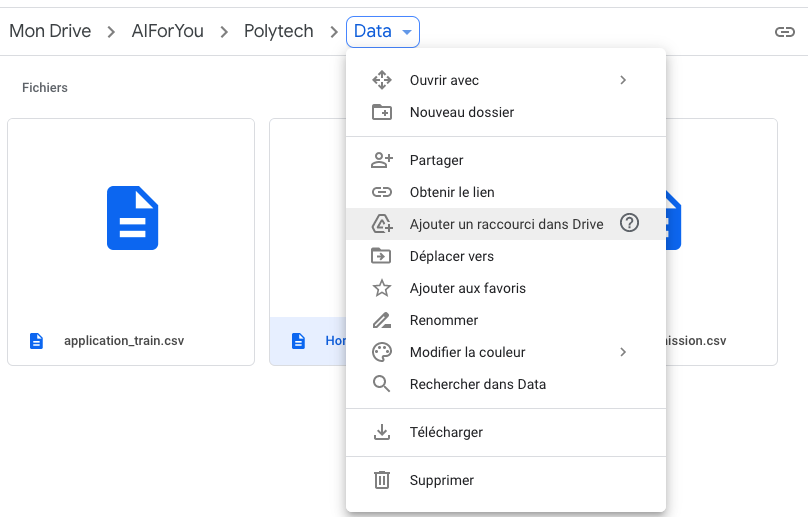

Add a shortcut to your drive.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Data import 

Import of the data to be used during model training.

In [3]:
data = pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks/credit_risk/Data/application_train.csv')

Quick overview of the data.

In [4]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Data exploration

Explore your data to see what it's made of. Think about visualising and quantifying the interactions between your explanatory data and your target variable.

In [5]:
data.shape

(307511, 122)

In [6]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   SK_ID_CURR                    int64  
 1   TARGET                        int64  
 2   NAME_CONTRACT_TYPE            object 
 3   CODE_GENDER                   object 
 4   FLAG_OWN_CAR                  object 
 5   FLAG_OWN_REALTY               object 
 6   CNT_CHILDREN                  int64  
 7   AMT_INCOME_TOTAL              float64
 8   AMT_CREDIT                    float64
 9   AMT_ANNUITY                   float64
 10  AMT_GOODS_PRICE               float64
 11  NAME_TYPE_SUITE               object 
 12  NAME_INCOME_TYPE              object 
 13  NAME_EDUCATION_TYPE           object 
 14  NAME_FAMILY_STATUS            object 
 15  NAME_HOUSING_TYPE             object 
 16  REGION_POPULATION_RELATIVE    float64
 17  DAYS_BIRTH                    int64  
 18  DAYS_EMPLOYED          

In [7]:
data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,

In [8]:
#get the disturbution of target
data['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [9]:
#get the correlation between target and other elements
data.corr()['TARGET'].abs().sort_values(ascending=False).head(20)

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
FLOORSMAX_AVG                  0.044003
FLOORSMAX_MEDI                 0.043768
FLOORSMAX_MODE                 0.043226
DAYS_REGISTRATION              0.041975
AMT_GOODS_PRICE                0.039645
OWN_CAR_AGE                    0.037612
Name: TARGET, dtype: float64

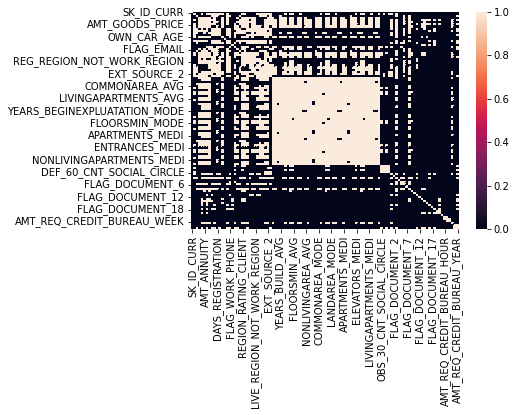

In [10]:
# create a heatmap to see the correlation between target and other elements
sns.heatmap(data.corr().abs()>0.03)

# Data selection

Select from among the available variables those that seem most promising for the training of your model.

In [11]:
# we can delete the lowest correlation element
del_data = data.corr()['TARGET'].abs().sort_values(ascending=True).head(20)

In [12]:
del_list = del_data.index
del_list

Index(['FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_5', 'FLAG_CONT_MOBILE', 'FLAG_MOBIL',
       'FLAG_DOCUMENT_12', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_7', 'NONLIVINGAPARTMENTS_MODE', 'FLAG_EMAIL',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'SK_ID_CURR', 'FLAG_DOCUMENT_4',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'NONLIVINGAPARTMENTS_MEDI',
       'LIVE_REGION_NOT_WORK_REGION', 'NONLIVINGAPARTMENTS_AVG',
       'FLAG_DOCUMENT_17'],
      dtype='object')

In [13]:
# delete the elements in del_list
data.drop(del_list,axis=1, inplace=True)

In [14]:
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,...,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,0,1,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,...,0.022,0.0198,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,0,1,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,...,0.079,0.0554,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,1,1,Religion,NaN,0.322738,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0


In [15]:
y = data['TARGET'].values
train_data = data.iloc[:,1:]
train_data.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,...,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,0,1,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,...,0.022,0.0198,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,0,1,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,...,0.079,0.0554,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,1,1,Religion,NaN,0.322738,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0


# Data Cleaning

Implement data cleaning to remove missing values.

In [16]:
types = np.array([z for z in train_data.dtypes])        
all_columns = train_data.columns.values
is_num = types != 'object'
num_features = all_columns[is_num].tolist()
cat_features = all_columns[~is_num].tolist()

print(len(num_features), "num features")
print(len(cat_features), "cat features")

85 num features
16 cat features


In [17]:
# for nan element,using SimpleImputer to handle the this problem.
# for different types, the fill_value is set differently.
features = num_features + cat_features
Pipe_num = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())       ])

Pipe_cat = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Unknown')),
    ('onehot', OneHotEncoder())        ])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', Pipe_num, num_features),
        ('cat', Pipe_cat, cat_features)])

preprocessor.fit(train_data[features])

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                  'AMT_CREDIT', 'AMT_ANNUITY',
                                  'AMT_GOODS_PRICE',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
                                  'FLAG_EMP_PHONE', 'FLAG_WORK_PH...
                                                                strategy='constant')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                      

# Data spliting

Sequencing of data sets for model training.

If you need help, feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, y, test_size=0.9, random_state=1)
print('the shape of X_train:',X_train.shape)
print('the shape of y_train:',y_train.shape)
print('the shape of X_valid:',X_valid.shape)
print('the shape of y_valid:',y_valid.shape)

the shape of X_train: (30751, 101)
the shape of y_train: (30751,)
the shape of X_valid: (276760, 101)
the shape of y_valid: (276760,)


# Establish a baseline model

Create a very simple template (without machine learning) that will serve as a reference for the rest of the project.

In [19]:
def train_model(model, param_grid=[], X_train=[], y_train=[], X_test=[], y_test=[]):

  gsearch = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='precision')
  gsearch.fit(X_train, y_train)

  # 提取最好的模型
  model = gsearch.best_estimator_
  # 预测

  print("Best model:")
  print(model)
  print('----------------------')
  print('The score for trainset: ', model.score(X_train, y_train))

  print("Detailed testset report:")
  print('The score for testset: ', model.score(X_test, y_test))
  proba = model.predict_proba(X_valid)[:,1]
  print("roc_auc_score of testset:",roc_auc_score(y_test, proba))

  return model

In [20]:
opt_models = dict()

# Use Logistic regression algorithm to train a model 

If you need help feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Data preprocessing

In [21]:
X_train = preprocessor.transform(X_train[features])
X_valid = preprocessor.transform(X_valid[features])

### Train your model on the training dataset

In [22]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=200, solver='saga')
lr_clf.fit(X_train, y_train)
roc_auc_score(y_train,lr_clf.predict_proba(X_train)[:,1])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


0.7615333463970777

### Evaluate your model on the testing dataset

In [23]:
roc_auc_score(y_valid,lr_clf.predict_proba(X_valid)[:,1])

0.7376430340316051

### Find the best set of hyperparameters

Feel free to find the best hyperparameters of the penalized logistic regression.

Use the Gridsearch algorithm to find the best set of hyparameters for your model. 

If you need feel free to chekc the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [24]:
from sklearn.linear_model import LogisticRegression
model = 'LR'
param_grid = {"max_iter":[100,200]}
opt_models[model] = train_model(LogisticRegression(solver='saga'), param_grid, X_train, y_train, X_valid, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Best model:
LogisticRegression(max_iter=200, solver='saga')
----------------------
The score for trainset:  0.9208481025007317
Detailed testset report:
The score for testset:  0.918727417256829
roc_auc_score of testset: 0.7376438817070227


### Graphical representation of the result

You can use ROC curve

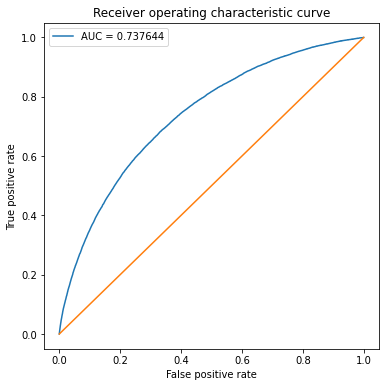

In [25]:
probabilities = opt_models['LR'].predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities)
auc = roc_auc_score(y_valid, probabilities)        
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)                                
plt.plot([0, 1], [0, 1])                                  
plt.title('Receiver operating characteristic curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(["AUC = %.6f"%auc])
plt.show()

### Interpret the coefficient

In [28]:
opt_models['LR'].coef_
coef_LR = pd.DataFrame(zip(opt_models['LR'].coef_[0], features), columns=['Value','Feature']).sort_values(by="Value", ascending=False)
coef_LR.head(20)

,Value,Feature
2,0.325107,AMT_CREDIT
16,0.165390,REGION_RATING_CLIENT_W_CITY
3,0.138415,AMT_ANNUITY
72,0.117020,FLAG_DOCUMENT_3
70,0.100841,DAYS_LAST_PHONE_CHANGE
20,0.094605,REG_CITY_NOT_LIVE_CITY
22,0.093235,LIVE_CITY_NOT_WORK_CITY
46,0.089851,FLOORSMAX_MODE
26,0.087610,APARTMENTS_AVG
40,0.081750,BASEMENTAREA_MODE


### Make a conclusion about this model to solve you scoring model

In [29]:
#LR模型对于该问题来说，出现了比较难收敛的情况，但其效果还是挺不错的。条件和时间允许的情况下，可以加大迭代次数，以及尝试多种solver，效果会更好

# Use decision tree algorithm to train a model

If you need help feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

### Train your model on the training dataset

In [30]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth=7)
dt_clf.fit(X_train, y_train)
roc_auc_score(y_train,dt_clf.predict_proba(X_train)[:,1])

0.7451598058359652

### Evaluate your model on the testing dataset

In [31]:
roc_auc_score(y_valid,dt_clf.predict_proba(X_valid)[:,1])

0.6919969889670228

### Find the best set of hyperparameters

Use the Gridsearch algorithm to find the best set of hyparameters for your model. 

If you need feel free to chekc the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [32]:
from sklearn.tree import DecisionTreeClassifier

model = 'DT'
param_grid = {"max_depth":[5,7,9,11]}
opt_models[model] = train_model(DecisionTreeClassifier(), param_grid, X_train, y_train, X_valid, y_valid)

Best model:
DecisionTreeClassifier(max_depth=5)
----------------------
The score for trainset:  0.922376508081038
Detailed testset report:
The score for testset:  0.9163607457725105
roc_auc_score of testset: 0.6951952116064355


### Graphical representation of the result

You can use ROC curve

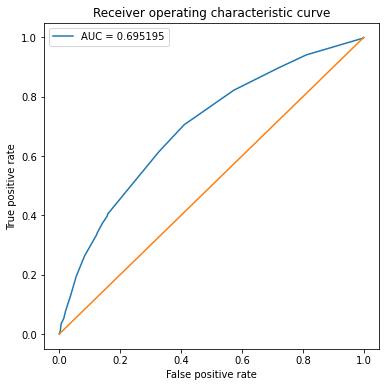

In [33]:
probabilities = opt_models['DT'].predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities)
auc = roc_auc_score(y_valid, probabilities)          
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)                      
plt.plot([0, 1], [0, 1])                   
plt.title('Receiver operating characteristic curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(["AUC = %.6f"%auc])
plt.show()

### Visualize the tree

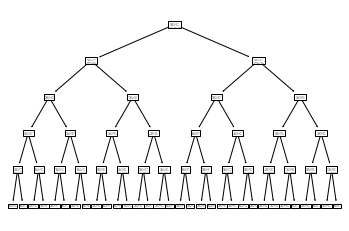

In [34]:
from sklearn.tree import plot_tree
plot_tree(opt_models['DT'])
plt.show()

### Make a conclusion about this model to solve you scoring model

In [35]:
#相比于前面的LR模型来说，该模型拟合的效果不是很好，但通过其gridSearch方法中选取的参数来看，深度越小居然效果更好。

# Use the random forest algorithm to train a model

If you need help feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

### Train your model on the training dataset

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=10)
rf_clf.fit(X_train, y_train)
roc_auc_score(y_train,rf_clf.predict_proba(X_train)[:,1])

0.9223676257782206

### Evaluate your model on the testing dataset

In [37]:
roc_auc_score(y_valid,rf_clf.predict_proba(X_valid)[:,1])

0.718791971427831

### Find the best set of hyperparameters

Use the Gridsearch algorithm to find the best set of hyparameters for your model. 

If you need feel free to chekc the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [38]:
model = 'RandomForestClassifier'
param_grid = {"n_estimators":[100,200],'max_depth':[9,11,13]}
opt_models[model] = train_model(RandomForestClassifier(), param_grid, X_train, y_train, X_valid, y_valid)

Best model:
RandomForestClassifier(max_depth=11)
----------------------
The score for trainset:  0.921335891515723
Detailed testset report:
The score for testset:  0.9190959676253794
roc_auc_score of testset: 0.7170473340964626


### Extract the feature importance of the model

In [39]:
importance_rf = pd.DataFrame(zip(opt_models['RandomForestClassifier'].feature_importances_, features), columns=['Value','Feature']).sort_values(by="Value", ascending=False)
importance_rf.head(20)

,Value,Feature
24,0.085140,EXT_SOURCE_2
25,0.074939,EXT_SOURCE_3
23,0.040413,EXT_SOURCE_1
6,0.029874,DAYS_BIRTH
7,0.027877,DAYS_EMPLOYED
9,0.025873,DAYS_ID_PUBLISH
8,0.023573,DAYS_REGISTRATION
70,0.022899,DAYS_LAST_PHONE_CHANGE
3,0.019556,AMT_ANNUITY
4,0.018293,AMT_GOODS_PRICE


### Graphical representation of the result

You can use ROC curve

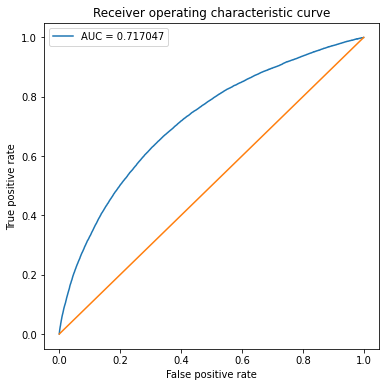

In [40]:
probabilities = opt_models['RandomForestClassifier'].predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities)
auc = roc_auc_score(y_valid, probabilities)             
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)                      
plt.plot([0, 1], [0, 1])                       
plt.title('Receiver operating characteristic curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(["AUC = %.6f"%auc])
plt.show()

### Make a conclusion about this model to solve you scoring model

In [41]:
#随机森林中树模型深度的增加并没有提高分类效果，其相比单颗树的效果来说，还是有提升的。但其与LR相比，可能并不太适合处理该问题

# Use AdaBoost algorithm to train a model

If you need help feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).

### Train your model on the training dataset

In [42]:
from sklearn.ensemble import AdaBoostClassifier
Ada_clf = AdaBoostClassifier(n_estimators=200)
Ada_clf.fit(X_train, y_train)
roc_auc_score(y_train,Ada_clf.predict_proba(X_train)[:,1])

0.7934036956119719

### Evaluate your model on the testing dataset

In [43]:
roc_auc_score(y_valid,Ada_clf.predict_proba(X_valid)[:,1])

0.728484551914119

### Find the best set of hyperparameters

Use the Gridsearch algorithm to find the best set of hyparameters for your model. 

If you need feel free to chekc the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [44]:
model = 'AdaBoostClassifier'
param_grid = {"n_estimators":[100,200]}
opt_models[model] = train_model(AdaBoostClassifier(), param_grid, X_train, y_train, X_valid, y_valid)

Best model:
AdaBoostClassifier(n_estimators=100)
----------------------
The score for trainset:  0.9206855061624012
Detailed testset report:
The score for testset:  0.9182360167654285
roc_auc_score of testset: 0.7327253259494094


### Extract the feature importance of the model

In [45]:
importance_Ada = pd.DataFrame(zip(opt_models['AdaBoostClassifier'].feature_importances_, features), columns=['Value','Feature']).sort_values(by="Value", ascending=False)
importance_Ada.head(20)

,Value,Feature
24,0.09,EXT_SOURCE_2
25,0.06,EXT_SOURCE_3
23,0.06,EXT_SOURCE_1
3,0.06,AMT_ANNUITY
70,0.05,DAYS_LAST_PHONE_CHANGE
9,0.05,DAYS_ID_PUBLISH
1,0.05,AMT_INCOME_TOTAL
6,0.04,DAYS_BIRTH
7,0.04,DAYS_EMPLOYED
8,0.03,DAYS_REGISTRATION


### Graphical representation of the result

You can use ROC curve

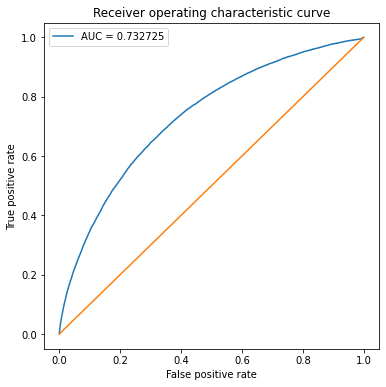

In [46]:
probabilities = opt_models['AdaBoostClassifier'].predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities)
auc = roc_auc_score(y_valid, probabilities)               
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)                                       
plt.plot([0, 1], [0, 1])        
plt.title('Receiver operating characteristic curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(["AUC = %.6f"%auc])
plt.show()

### Make a conclusion about this model to solve you scoring model

In [47]:
#与RandomFores同为集成模型，AdaBoost的效果有了进一步的提升

# Use Gradient Boosting Tree algorithm to train a model

If you need help feel free to check the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

### Train your model on the training dataset

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
GB_clf = GradientBoostingClassifier(n_estimators=200, max_depth=6)
GB_clf.fit(X_train, y_train)
roc_auc_score(y_train,GB_clf.predict_proba(X_train)[:,1])

0.9564256951373012

### Evaluate your model on the testing dataset

In [49]:
roc_auc_score(y_valid,GB_clf.predict_proba(X_valid)[:,1])

0.7313792877042073

### Find the best set of hyperparameters

Use the Gridsearch algorithm to find the best set of hyparameters for your model. 

If you need feel free to chekc the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [50]:
model = 'GradientBoostingClassifier'
param_grid = {'max_depth':[6]}
opt_models[model] = train_model(GradientBoostingClassifier(loss='exponential'), param_grid, X_train, y_train, X_valid, y_valid)

Best model:
GradientBoostingClassifier(loss='exponential', max_depth=6)
----------------------
The score for trainset:  0.9257259926506455
Detailed testset report:
The score for testset:  0.919041769041769
roc_auc_score of testset: 0.7399308703034229


### Extract the feature importance of the model

In [51]:
importance_GB = pd.DataFrame(zip(opt_models['GradientBoostingClassifier'].feature_importances_, features), columns=['Value','Feature']).sort_values(by="Value", ascending=False)
importance_GB.head(20)

,Value,Feature
24,0.132892,EXT_SOURCE_2
25,0.122202,EXT_SOURCE_3
23,0.058687,EXT_SOURCE_1
6,0.050563,DAYS_BIRTH
9,0.038311,DAYS_ID_PUBLISH
7,0.036715,DAYS_EMPLOYED
8,0.035186,DAYS_REGISTRATION
3,0.032192,AMT_ANNUITY
2,0.025877,AMT_CREDIT
1,0.021794,AMT_INCOME_TOTAL


### Graphical representation of the result

You can use ROC curve

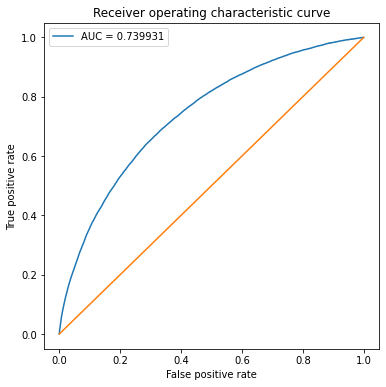

In [52]:
probabilities = opt_models['GradientBoostingClassifier'].predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities)
auc = roc_auc_score(y_valid, probabilities)               
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)                                        
plt.plot([0, 1], [0, 1])              
plt.title('Receiver operating characteristic curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(["AUC = %.6f"%auc])
plt.show()

### Make a conclusion about this model to solve you scoring model

In [53]:
# 与前两个集成模型相比，效果有了提升，但模型相应的复杂度也在增加，在拟合数据上花的时间内，相比于前两个集成模型，多了很多。

# Use Support Vector Machine to train a model

Use the same structure as before

### Train your model on the training dataset

In [73]:
from sklearn.svm import SVC
# you can use probability=True when you have much time, and you can try to set max_iter more larger
svc_clf = SVC(kernel='rbf', max_iter=4000, probability=True)
svc_clf.fit(X_train, y_train)
roc_auc_score(y_train,svc_clf.predict_proba(X_train)[:,1])
#svc_clf.score(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


0.8883018812517249

### Evaluate your model on the testing dataset

In [74]:
roc_auc_score(y_valid,svc_clf.predict_proba(X_valid)[:,1])
#svc_clf.score(X_valid, y_valid)

0.600830649063106

### Find the best set of hyperparameters


In [75]:
model = 'SVC'
param_grid = {'kernel':['rbf'],'max_iter':[4000]}
svc_grid = GridSearchCV(SVC(probability=True), param_grid, cv=2)
svc_grid.fit(X_train, y_train)
opt_models[model] = svc_grid.best_estimator_
# when you use SVC with proba, you can use below gridsearch
# opt_models[model] = train_model(SVC(gamma='auto')), param_grid, X_train, y_train, X_valid, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


### Graphical representation of the result

You can use ROC curve

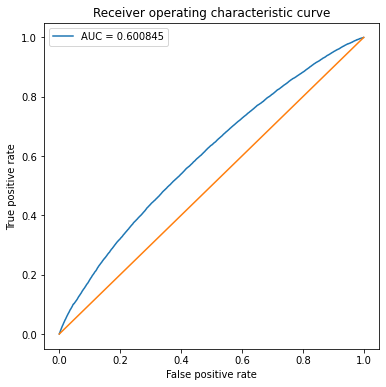

In [76]:
# when you use SVC with proba, you can use below graphtools
probabilities = opt_models['SVC'].predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities)
auc = roc_auc_score(y_valid, probabilities)              
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)                                       
plt.plot([0, 1], [0, 1])
plt.title('Receiver operating characteristic curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(["AUC = %.6f"%auc])
plt.show()

### Make a conclusion about this model to solve you scoring model

In [ ]:
# 对于SVM模型，通过实验发现，线性核无法收敛，故采用了非线性核，拟合时间也较为长，特别是当需要输出probability时，所以在拟合过程中限制了迭代次数。
# 但其在训练集上表现的AUC，在一定程度上也是过拟合的，可见其效果不是很好

# Compare all you model to solve the scoring problem

### Metrics comparaison

In [77]:
model_results = pd.DataFrame(columns = ['The name of model','AUC_Train', 'AUC_Valid'])

for model in opt_models.keys():
  # if you train SVC with probability=True, you can delete 'SVC'. 
  # if model not in ['SVC']:
  model_results = model_results.append({'The name of model':model, 'AUC_Train' :roc_auc_score(y_train, opt_models[model].predict_proba(X_train)[:, 1]), 
                          'AUC_Valid' : roc_auc_score(y_valid, opt_models[model].predict_proba(X_valid)[:, 1])}, ignore_index=True)
model_results

,The name of model,AUC_Train,AUC_Valid
0,LR,0.761535,0.737644
1,DT,0.724777,0.695195
2,RandomForestClassifier,0.941848,0.717047
3,AdaBoostClassifier,0.777672,0.732725
4,GradientBoostingClassifier,0.887758,0.739931
5,SVC,0.888384,0.600845


### Graphical comparaison

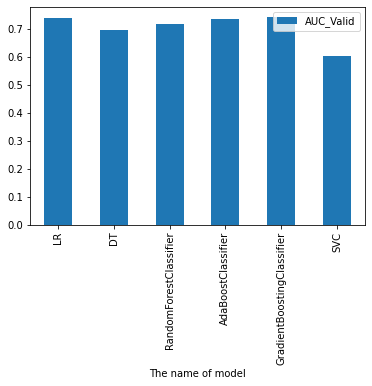

In [78]:
model_results.loc[:,['The name of model','AUC_Valid']].plot(x='The name of model', y='AUC_Valid',kind='bar')

### Submit your result on Kaggle

In [57]:
test_data = pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks/credit_risk/Data/application_test.csv')
test_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
t_data = test_data.drop(del_list,axis=1)
t_data.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,...,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,0,0,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,...,NaN,0.0526,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
1,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,3.0
2,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,4.0
3,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,0,1,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,...,0.2626,0.3827,0.0847,0.3081,0.1974,0.9970,0.9597,0.1173,0.32,0.2759,0.375,0.0417,0.2078,0.2446,0.3739,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,3.0
4,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,1,1,Business Entity Type 3,0.202145,0.425687,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN


In [59]:
t_testdata = preprocessor.transform(t_data[features])
proba = opt_models['GradientBoostingClassifier'].predict_proba(t_testdata)[:,1]
proba.shape

In [65]:
df_result = pd.DataFrame({'SK_ID_CURR':test_data.loc[:,'SK_ID_CURR'], 'TARGET':proba})
df_result.head()

,SK_ID_CURR,TARGET
0,100001,0.032173
1,100005,0.062922
2,100013,0.014973
3,100028,0.010721
4,100038,0.121534


In [68]:
df_result.to_csv('/content/gdrive/MyDrive/ColabNotebooks/credit_risk/submission.csv',index=False,header=True)

submit this csv file to kaggle, the result is 0.73159

# Make a general conclusion for this project

In [ ]:
#比较6个模型，容易发现，LR作为一种简单模型，其效果与集成模型中的GBDT相当，这也说明了，对于数据预处理出得到的特征，更适合LR模型去拟合，而不太适合以树模型为基础的RandomForest、Adaboost和GBDT。
#与此同时，复杂的单一模型SVC，在该问题上，过拟合严重。
#另一方面，理论上，集成模型的特性应该会使得自身的拟合效果比单一模型要好，通过上面的实验，说明了数据决定了很多模型的好坏。总的来说，数据分析的能力在处理机器学习问题中至关重要。